In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import maxentep
# disabling gpu for now
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
EPS = np.finfo(np.float32).tiny
param_batch_size = 1024
maxent_batch_size = 32
sns.set_context('notebook')

In [2]:
def ridge_plot(df, var_name, weighted=True):
    # Initialize the FacetGrid object
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    pal = sns.cubehelix_palette(i + 1, rot=-.25, light=.7)
    g = sns.FacetGrid(params_df, row="labels", hue="labels", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map_dataframe(sns.kdeplot, var_name, clip_on=False, shade=True, alpha=1, lw=1.5, weights="weights" if weighted else None)
    g.map_dataframe(sns.kdeplot, var_name, clip_on=False, color="w", lw=2, weights="weights" if weighted else None)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)    


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, var_name)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

## Set-up Starting Guesses

In [3]:
M = 3
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
# make some elements zero
R[0,2] = 0
R[1,2] = 0
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.86440855, 0.13559145, 0.        ],
        [0.7408696 , 0.2591304 , 0.        ],
        [0.02148006, 0.43990458, 0.53861536]]),
 array([1., 1., 1.]))

In [4]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'A', 5, 2)
tmat.add_norm_dist('A', 'I', 3, 2)
tmat.add_norm_dist('I', 'R', 14, 4)
T = tmat.sample(1)[0]
np.sum(T, axis=1)
T

array([[0.78356299, 0.21643701, 0.        , 0.        ],
       [0.        , 0.70392858, 0.29607142, 0.        ],
       [0.        , 0.        , 0.9566332 , 0.0433668 ],
       [0.        , 0.        , 0.        , 1.        ]])

In [5]:
start = np.zeros((M, C))
start[0, 1] = 0.1

## Set-up unbiased model

In [6]:
i = tf.keras.layers.Input((1,))

In [7]:
# infection parameter first
beta_low = 0.01
beta_high = 0.7
beta_var = 0.1
beta_layer = tf.keras.layers.Dense(
    1, 
    use_bias=False, 
    kernel_constraint=tf.keras.constraints.MinMaxNorm(beta_low, beta_high),
    kernel_initializer = tf.keras.initializers.Constant(0.2),
    name='beta-unbiased')
beta_dist = tfp.layers.DistributionLambda(
    lambda b: tfd.TruncatedNormal(loc=b, scale=beta_var, low=0.0, high=beta_high + beta_var),
    name='beta-unbiased-dist'
)(beta_layer(i))

In [8]:
R_dist = maxentep.normal_mat_layer(i, R, name='R-unbiased')
T_dist =  maxentep.dirichlet_mat_layer(i, T, name='T-unbiased')
start_dist = maxentep.normal_mat_layer(i, start, clip_high=0.5, name='rho-unbiased')
unbiased_model = tf.keras.Model(inputs=i, outputs=[R_dist, T_dist, start_dist, beta_dist], name='unbiased-model')
unbiased_joint = unbiased_model(tf.constant([1.]))

## Create Trainable Model

In [9]:
i = tf.keras.layers.Input((1,))
# infection parameter first
beta_layer = tf.keras.layers.Dense(
    1, 
    use_bias=False,
    kernel_initializer = tf.keras.initializers.Constant(0.2),
    kernel_constraint=tf.keras.constraints.MinMaxNorm(beta_low, beta_high),
    name='beta')
beta_dist = tfp.layers.DistributionLambda(
    lambda b: tfd.TruncatedNormal(loc=b, scale=beta_var, low=0.0, high=beta_high + 3 * beta_var),
    name='beta-dist'
)(beta_layer(i))
R_dist = maxentep.normal_mat_layer(i, R, name='R')
T_dist =  maxentep.dirichlet_mat_layer(i, T, name='T')
start_dist = maxentep.normal_mat_layer(i, start, clip_high=0.5, name='rho')
model = tf.keras.Model(inputs=i, outputs=[R_dist, T_dist, start_dist, beta_dist], name='param-model')

## Set-up loglikelihood

In [10]:
def cross_entropy(y, rv_y):
    #print(tf.shape(w), tf.shape(y), rv_y)
    # reduce across other axis (summing independent variable log ps)
    logp = rv_y.log_prob(y + EPS)
    logp = tf.reduce_sum(tf.reshape(logp, (tf.shape(y)[0], -1)), axis=1)
    return -logp
model.compile(tf.optimizers.Adam(1e-3), loss=[cross_entropy, cross_entropy, cross_entropy, cross_entropy])
model.summary()

Model: "param-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-hypers (TrainableInputLayer)  (1, 2, 3, 3)         18          input_2[0][0]                    
__________________________________________________________________________________________________
T-hypers (TrainableInputLayer)  (1, 4, 4)            16          input_2[0][0]                    
__________________________________________________________________________________________________
rho-hypers (TrainableInputLayer (1, 2, 3, 4)         24          input_2[0][0]                    
________________________________________________________________________________________

## Make some restraints

In [11]:
r1 = maxentep.Restraint(lambda x: x[...,25,0,2], 0.4, maxentep.EmptyPrior())
r2 = maxentep.Restraint(lambda x: x[...,50,0,2], 0.2, maxentep.EmptyPrior())

## Maxent Model

In [12]:
infect = maxentep.contact_infection_func(infections_compartments)
traj_model_layer = maxentep.MetapopLayer(100, infect)
traj_layer = maxentep.AddSusceptibleLayer()
maxent_model = maxentep.MaxentModel([r1, r2])
maxent_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

## Visualize Unbiased

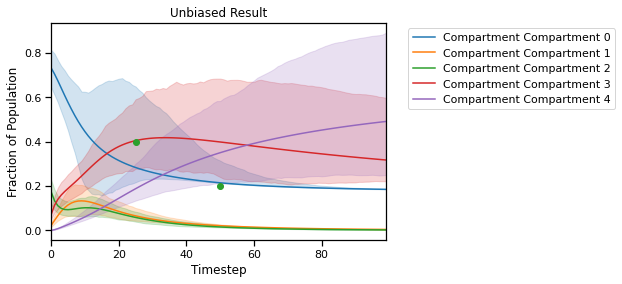

In [13]:
psample = [j.sample(param_batch_size) for j in unbiased_joint]
trajs = traj_layer(traj_model_layer(psample))
maxentep.traj_quantile(trajs[:,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Unbiased Result')

# have to rebuild, since we induced inputs by running above code (batch = dim 1)
traj_model_layer = maxentep.MetapopLayer(100, infect)
traj_layer = maxentep.AddSusceptibleLayer()

## Create Re-Weighter

In [14]:
def reweight(samples, joint):
    batch_dim = samples[0].shape[0]
    logit = tf.zeros((batch_dim,))
    for i,(uj,j) in enumerate(zip(unbiased_joint, joint)):
        # reduce across other axis (summing independent variable log ps)
        logitdiff = uj.log_prob(samples[i] + EPS) - j.log_prob(samples[i] + EPS)
        logit += tf.reduce_sum(tf.reshape(logitdiff, (batch_dim, -1)), axis=1)
    return tf.math.softmax(logit)

## Try to reweight without hyper-parameter tuning

In [15]:
me_loss = []
# sample and get batch
joint = model(tf.constant([0.]))
psample = [j.sample(param_batch_size) for j in joint]    
x = traj_model_layer(psample)
trajs = traj_layer(x)
# get weights of trajectories
h = maxent_model.fit(trajs, batch_size=maxent_batch_size, epochs=128, verbose=False)
me_loss.extend(h.history['loss'])
w = maxent_model.traj_weights

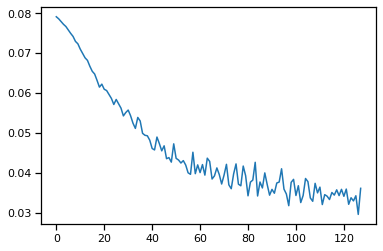

In [16]:
plt.plot(me_loss)
plt.show()

Text(0.5, 1.0, 'Maxent Result')

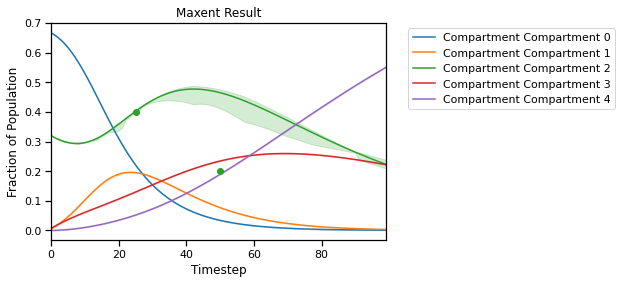

In [17]:
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result')

## Now tune hyperparameters at the same time

In [18]:
me_loss = []
p_loss = []
obs_betas = []
obs_weights = []
obs_labels = []
weight_entropy = []
steps = 16

pb = tqdm.tqdm(range(steps))
for i in pb:
    # sample and get batch
    joint = model(tf.constant([1.]))
    psample = [j.sample(param_batch_size) for j in joint]        
    x = traj_model_layer(psample)
    trajs = traj_layer(x)
    # get reweight logits
    rw = reweight(psample, joint)
    # get weights of trajectories
    h = maxent_model.fit(trajs, input_weights=rw, batch_size=maxent_batch_size, epochs=10, verbose=False)
    me_loss.extend(h.history['loss'])
    w = maxent_model.traj_weights
    weight_entropy.append(np.sum(-w * np.log(w)))
    pb.set_description('entropy: ' + str(weight_entropy[-1]))
    
    # add to data we're tracking
    obs_betas.extend(psample[3].numpy().reshape(-1))
    obs_labels.extend(param_batch_size * [f'Step {i}'])
    obs_weights.extend(w.numpy())
    
    # now use these to train hyper-parameters
    fake_x = tf.constant(param_batch_size * [1.])
    h = model.fit(fake_x, psample, batch_size=maxent_batch_size, 
                  sample_weight=w,verbose=False, epochs=10)
    p_loss.extend(h.history['loss'])

entropy: 6.36824: 100%|███████████████████████████████████████████████████████| 16/16 [00:31<00:00,  1.99s/it]


## Now do final sample/weight with trained hyperparameters

In [19]:
# Now finish with tuned hyperparameters
# sample and get batch
joint = model(tf.constant([1.]))
psample = [j.sample(param_batch_size) for j in joint]    
x = traj_model_layer(psample)
trajs = traj_layer(x)
# get reweight logits
rw = reweight(psample, joint)
h = maxent_model.fit(trajs, input_weights=rw, batch_size=maxent_batch_size, epochs=256, verbose=False)
me_loss.extend(h.history['loss'])
w = maxent_model.traj_weights
weight_entropy.append(np.sum(-w * np.log(w)))
# add to data we're tracking
obs_betas.extend(psample[3].numpy().reshape(-1))
obs_labels.extend(param_batch_size * [f'Step {steps}'])
obs_weights.extend(w.numpy())

## Examine how parameters changed

In [20]:
params_df = pd.DataFrame({
    'beta': obs_betas,
    'labels': obs_labels,
    'weights': obs_weights
})
params_df.head()

,beta,labels,weights
0,0.178718,Step 0,1.291437e-07
1,0.179409,Step 0,3.804388e-07
2,0.144635,Step 0,1.046278e-06
3,0.356452,Step 0,3.460839e-08
4,0.184273,Step 0,8.698057e-01


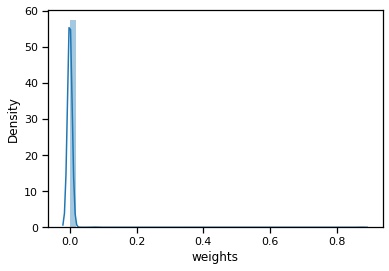

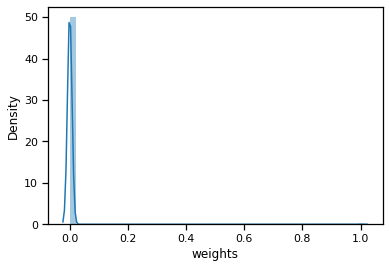

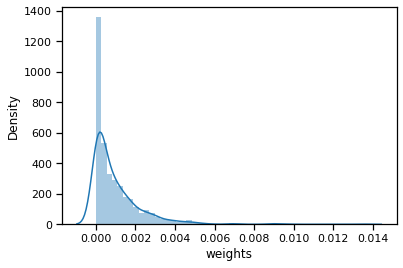

In [24]:
sns.distplot(x = params_df[(params_df['labels'] == 'Step 0')]['weights'])
plt.show()
sns.distplot(x = params_df[(params_df['labels'] == 'Step 1')]['weights'])
plt.show()
sns.distplot(x = params_df[(params_df['labels'] == f'Step {steps}')]['weights'])

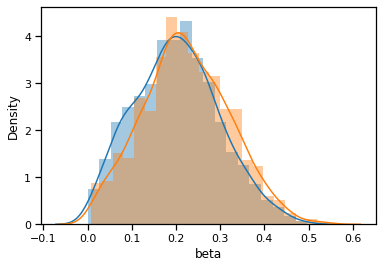

In [26]:
sns.distplot(x=params_df[params_df['labels'] == 'Step 0']['beta'])
sns.distplot(x=params_df[params_df['labels'] == f'Step {steps}']['beta'])
plt.show()

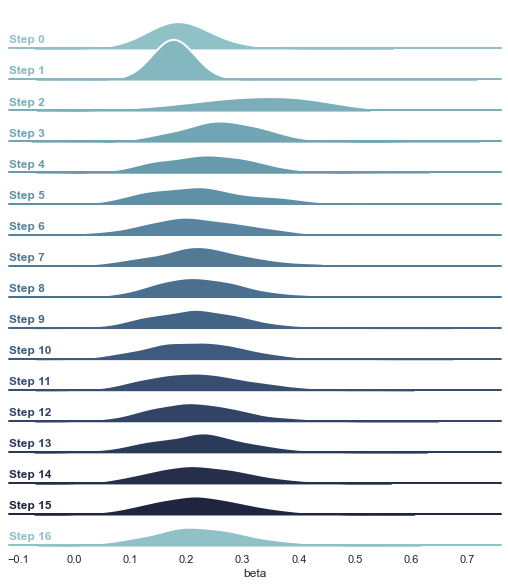

In [28]:
ridge_plot(params_df, 'beta')

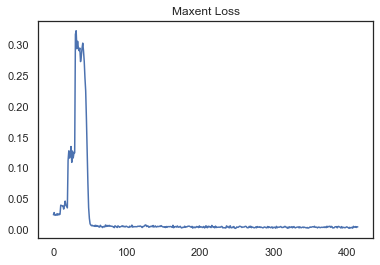

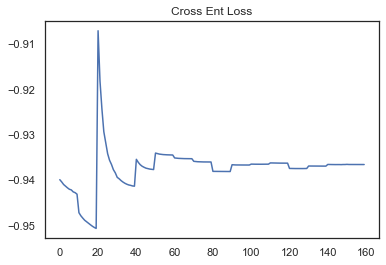

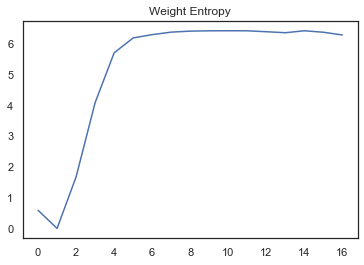

In [29]:
plt.plot(me_loss)
plt.title('Maxent Loss')
plt.show()
plt.plot(p_loss)
plt.title('Cross Ent Loss')
plt.show()
plt.plot(weight_entropy)
plt.title('Weight Entropy')
plt.show()

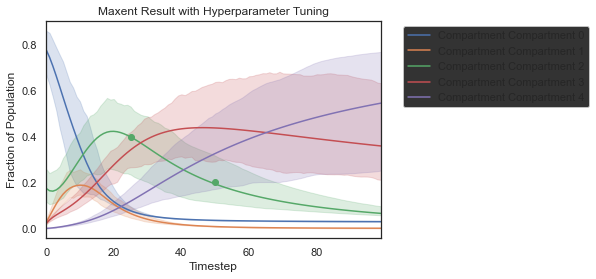

Text(0.5, 1.0, 'Maxent Result with Hyperparameter Tuning - Patch 2')

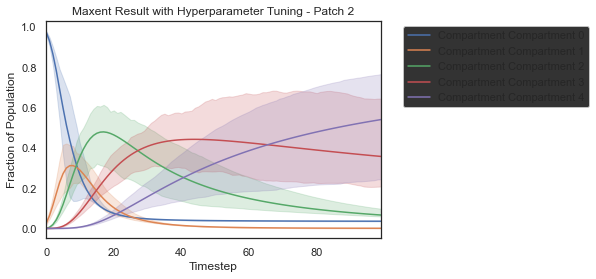

In [30]:
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result with Hyperparameter Tuning')
plt.show()

maxentep.traj_quantile(trajs[:,:,2,:], weights=w)
plt.title('Maxent Result with Hyperparameter Tuning - Patch 2')

## Now compare with Directed regression

In [31]:
infect = maxentep.ContactInfectionLayer(0.1, infections_compartments)
reg_model = maxentep.TrainableMetaModel(start, R, T, infect, 100, lambda traj: (r1(traj)**2 + r2(traj)**2))

In [32]:
reg_model.compile(optimizer=tf.keras.optimizers.Adam(0.01))
reg_model.fit(epochs=1, verbose=True)

100/100 [==============================] - 3s 34ms/step - loss: 0.0259 - output_2_loss: 0.0259


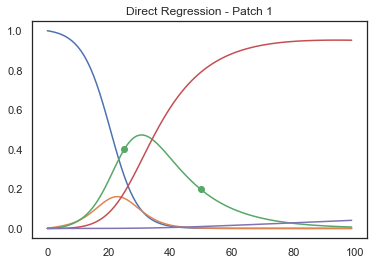

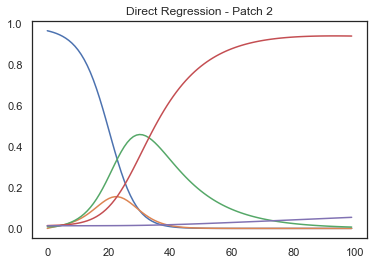

In [33]:
traj = reg_model.get_traj()
plt.plot(traj[0,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Direct Regression - Patch 1')
plt.show()
traj = reg_model.get_traj()
plt.plot(traj[0,:,1,:])
plt.title('Direct Regression - Patch 2')
plt.show()